# Пример получения прогноза ИПЦ


In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import requests
import json

# Список признаков

In [10]:
base_url = 'http://localhost:5051/forecast/api'

feature_list = requests.get(url=base_url + '/v1/ipc/features_list').json()
feature_list

{'interest_rate': {'dataset_uuid': '87d93650-33f7-44b2-96df-6d520fa76c12',
  'description': 'Базовая ставка - краткосрочная, %, Россия'},
 'curs': {'dataset_uuid': '5e5ac82a-ab76-4567-b095-92f8064acb51',
  'description': 'Официальный курс доллара США на заданную дату, устанавливаемый ежедневно'},
 'money_supply': {'dataset_uuid': '92b26933-97ab-45ab-9d52-18f509e193cb',
  'description': 'Денежная масса, млрд нац ден ед, Россия'},
 'm0_agg': {'dataset_uuid': 'None',
  'description': 'Денежный аггрегат М0, Россия'}}

# Импорт данных

In [9]:
ipc = pd.read_csv(f'./raw_data/Базовый индекс потребительских цен.csv', sep=';')
ipc.head(3)

,dataset,date,"Базовый индекс потребительских цен, индекс, Россия"
0,69798,31.01.2003,1.0120
1,69798,28.02.2003,1.0088
2,69798,31.03.2003,1.0068


In [69]:
path = './raw_data/'

interest_rate = pd.read_csv(path + '/87d93650-33f7-44b2-96df-6d520fa76c12.csv', sep=';')
curs = pd.read_csv(path + '5e5ac82a-ab76-4567-b095-92f8064acb51.csv', sep=';')
money_supply = pd.read_csv(path + 'Денежная масса, млрд нац ден ед, Россия — Диаграмма.csv', sep=';')

# не добавили на сайт, беру из папки
m0_agg = pd.read_csv(path + 'Денежный аггрегат M0.csv')

In [71]:
m0_agg

,date,Денежный агрегат М0
0,01.01.2001,418.9
1,01.02.2001,379.7
2,01.03.2001,387.6
3,01.04.2001,399.0
4,01.05.2001,435.0
...,...,...
264,01.01.2023,15435.7
265,01.02.2023,15361.2
266,01.03.2023,15576.6
267,01.04.2023,15819.6


# Формирование запроса

In [72]:
catboost_params = {
    "depth": 3,
    "learning_rate": 1,
    "l2_leaf_reg": 0.005,
    "iterations": 8
}

In [74]:
url = base_url + '/v1/ipc/catboost'

data = {
    "hparams":  catboost_params,    
    "ipc":      {
        "dates": list(ipc.date),
        "values": list(ipc['Базовый индекс потребительских цен, индекс, Россия'])
    },
    "features": {
        "curs":          {"dates": list(curs.date),          "values": list(curs['values'])},
        "interest_rate": {"dates": list(interest_rate.date), "values": list(interest_rate['values'])},
        "money_supply":  {"dates": list(money_supply.date),  "values": list(money_supply['Денежная масса, млрд нац ден ед, Россия'])},
        "agg_m0":        {"dates": list(m0_agg.date),        "values": list(m0_agg['Денежный агрегат М0'])}
    }
}

# Отправляем запрос

In [106]:
with requests.post(url=url, json=data) as response:
    print(f'{response.status_code = }')
    forecast = response.json()

response.status_code = 200


In [107]:
forecast

{'previous': [1.0351326929236637,
  1.0235760391309061,
  1.0122924496285175,
  1.006366770677454,
  1.006366770677454,
  1.0054918109266124,
  1.0054918109266124,
  1.0062125700316151,
  1.006366770677454,
  1.0064213007477012,
  1.0056366867353268,
  1.0050742993736455,
  1.009174631709322,
  1.0081550767252563,
  1.0064298078411347,
  1.0054918109266124,
  1.0054918109266124,
  1.0054918109266124,
  1.003703411624061,
  1.0042519611322986,
  1.003703411624061,
  1.0041363024591232,
  1.0023479031565719,
  1.0036936610276344,
  1.0023475552717231,
  1.0036936610276344,
  1.0017892551670589,
  1.0018866371978603,
  1.0018866371978603,
  1.0018866371978603,
  1.0018866371978603,
  1.0018866371978603,
  1.0018866371978603,
  1.0017892551670589,
  1.0018866371978603,
  1.0018866371978603,
  1.0023475552717231,
  1.0017892551670589,
  1.0018866371978603,
  1.0018866371978603,
  1.0017892551670589,
  1.0017892551670589,
  1.0042519611322986,
  1.0023475552717231,
  1.0042519611322986,
  1.

# Визуализация

In [108]:
import matplotlib.pyplot as plt
from datetime import datetime

In [113]:
ipc.date = pd.to_datetime(ipc.date, format='%d.%m.%Y')
ipc.tail(3)

,dataset,date,"Базовый индекс потребительских цен, индекс, Россия"
243,69798,2023-04-30,1.0031
244,69798,2023-05-31,1.0052
245,69798,2023-06-30,1.0049


In [122]:
next_data = [datetime(year=2023, month=i, day=1) for i in range(7, 10)]

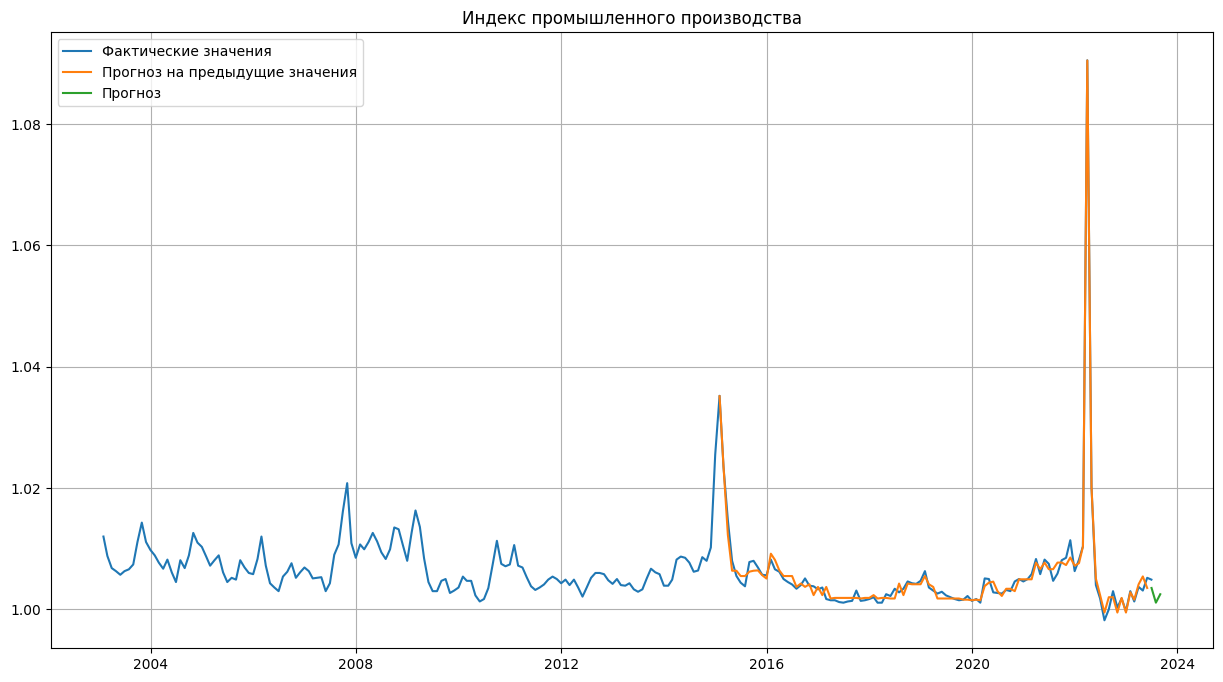

In [127]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.set_title('Индекс потребительских цен')

ax.plot(ipc.date, ipc['Базовый индекс потребительских цен, индекс, Россия'], label='Фактические значения')
ax.plot(ipc[ipc.date >= datetime(year=2015, month=1, day=1)]['date'][:-1], forecast['previous'], label='Прогноз на предыдущие значения')
ax.plot(next_data, forecast['predict'], label='Прогноз')

ax.legend()
ax.grid()